

# re:Invent 2022 workshop AIM342: Advancing Responsible AI
## Digit Classification on the MNIST Dataset

This notebook includes experiments on the MNIST dataset of black-and-white handwritten digits [0-9], available from [1] and described in [2] and [3]. You will download the data from a public repository and train a machine-learned model to perform digit classification: given an input image, produce the identity [0-9] of the digit. You will explore a version of this dataset augmented with color, and explore unwanted bias: disparities in classification accuracy, based on membership in a group such as *even numbers* or *curvy numbers*. You will compare metrics for measuring bias, and explore the effect of balanced/unbalanced training and evaluation data when calculating bias results. You will compare bias for subsets of data defined by one or more intersectional attributes (like identity=6 && color=red), and explore causes of disparity that may interact with bias.


You may run this notebook by selecting Run->Run All Cells from the menu above. Make sure you select the `Python 3 (Data Science)` kernel in Studio, or `conda_pytorch_p36` in your notebook instance.

 Enjoy!

1. LeCun, Yann and Cortes, Corinna and Burges, CJ. (2010). MNIST handwritten digit database. ATT Labs. [Online](http://yann.lecun.com/exdb/mnist)
2. Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. (1998) "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998. [Online](http://yann.lecun.com/exdb/publis/index.html#lecun-98)
3. Deng, L. (2012). [The mnist database of handwritten digit images for machine learning research](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MNIST-SPM2012.pdf). IEEE Signal Processing Magazine, 29(6), 141–142.


## Learning Objectives
In this workshop you will learn to
* Train a baseline model
* Measure classification accuracy
* Measure and visualize bias: disparities in accuracy for subsets of the data
* Compare bias metrics: relative vs. absolute, error vs. accuracy
* Compare test sets: balanced/unbalanced evaluation data and confidence intervals
* Address balanced/unbalanced training data with resampling
* Explore bias at aggregate vs intersectional granularity (confidence intervals and Simpson's Paradox)
* Disentangle competing causes of bias (typical vs. atypical examples)

## Runtime
This module takes about 40-60 minutes to run.

## Contents
1. [Setup](#Setup)
1. [Download the dataset](#Download-and-prepare-the-dataset)
1. [Train a baseline model](#Train-a-baseline-model)
1. [Measure accuracy](#Measure-accuracy)
1. [Measure bias](#Measure-bias)
1. [Compare bias metrics](#Compare-bias-metrics)
1. [Compare test sets](#Compare-test-sets)
1. [Balanced training data](#Balanced-training-data)
1. [Intersectionality](#Intersectionality)
1. [Causality](#Causality)
1. [Conclusions](#Conclusions)




# Setup

Select the `Python 3 (Data Science)` kernel in Studio, or `conda_pytorch_p36` in your notebook instance.

This kernel includes pytorch, numpy, pillow, matplotlib, torch, torchvision, cv2, and pandas, which you need for this notebook.

Execute (Shift+Enter) the cell below if these libraries are not available in your Python environment.

In [1]:
# This version will work for most systems; if pip3 is your default installer, try the `pip3` version, below (next cell)
!pip install matplotlib \
    numpy \
    opencv-python \
    pandas \
    Pillow \
    scikit-learn \
    torch \
    pandas \
    seaborn \
    torchvision >/dev/null 2>&1

In [2]:
# Uncomment and execute this version if `pip` failed because pip3 is your default installer 
'''
!pip3 install matplotlib \
    numpy \
    opencv-python \
    pandas \
    Pillow \
    scikit-learn \
    torch \
    pandas \
    seaborn \
    torchvision >/dev/null 2>&1
'''

'\n!pip3 install matplotlib     numpy     opencv-python     pandas     Pillow     scikit-learn     torch     pandas     seaborn     torchvision >/dev/null 2>&1\n'

### Imports

In [3]:
# Imports

from dataset_utils import *
from train_utils import *
from plotting import *

# Download and prepare the dataset

We will download the dataset using the torchvision.datasets library and define some important attributes for bias analysis.

## Define groups

When inputs represent people, as in face, voice, or speech recognition, we can define groups by demographic attributes like gender, age, or race. This helps us measure and mitigate bias that could lead to one customer experiencing better or worse performance than another.

In this notebook, we train a computer vision model where input images represent numbers. We define groups by attributes of these numbers, which will serve as an analogy to demographics. 

We start with digit identity, measuring whether the model performs equally well for 0's, 3's, 8's, etc. In addition to identity, we can explore numerical attributes like *parity*: is a number even or odd; and *magnitude*: is the number big/medium/small? Numbers can also have visual attributes: 3's and 8's are curvy, while 1's, and 4's are linear. Finally, we augment the images with color, so that a random percentage *p* of the images have color red, while the rest have color green.

Each attribute defines a dimension along which we can measure bias. Because an image has several attributes, we can also identify bias among *intersections*: numbers that are curvy & small, or odd & linear. In real-world applications, these intersections become granular descriptions of customer communities we care about, like "Women over 50" or "Asian Men". 

In [4]:
# Download mnist as a torchvision dataset, do some prep, 
# and return two pandas DataFrames: train_data and test_data
#
#
#           This may take 15s
train_data, test_data = create_starting_data()

The starting dataset should contain ~46K training images and 10K test images. 

In [5]:
# Check that we got the right number of images
print(f'The starting dataset has {len(train_data)} training instances and {len(test_data)} test instances.')

The starting dataset has 46620 training instances and 10000 test instances.


Here is an example of each digit. 

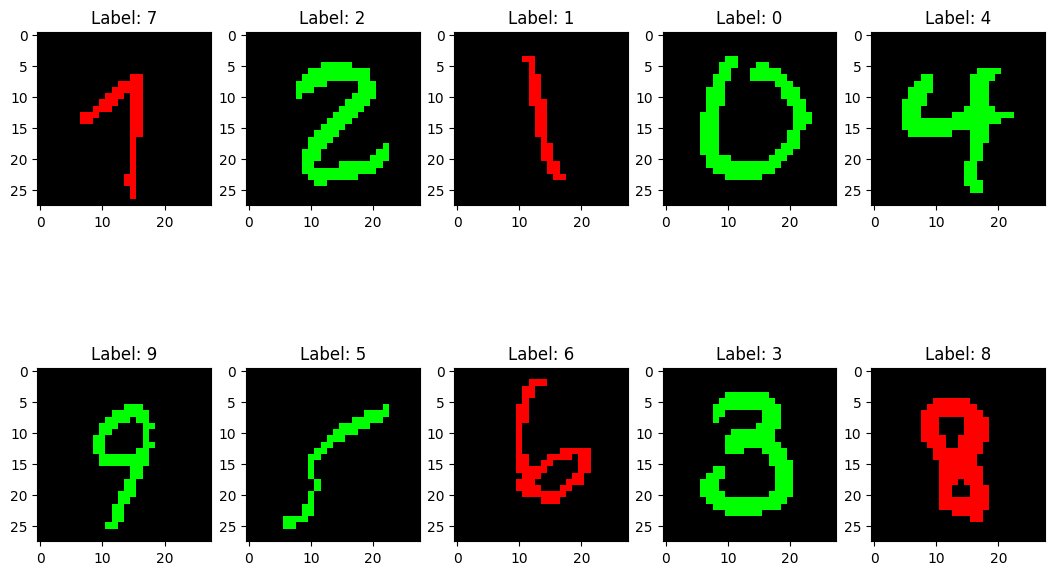

In [6]:
# Randomly select one image from each digit group and display. 
# 
# Run the cell multiple times to view different examples.
from plotting import plot_one_each
plot_one_each(test_data)

## Group distributions

Now let's look at our groups. 

We have several attributes: 
* digit = [0,9]
* magnitude = {big, med, small}
* parity = {even, odd}
* curve = {curves, lines, mixed}
* color = {red, green}.

All of these are captured in the columns of our dataframe object for test_data and for train_data.

In addition the dataframe holds the image itself ('img') and the ground truth label for the image ('label'), which is currently matches the 'digit'.

In [7]:
# Verify the columns on the test dataset
print('Test data columns: ', test_data.columns)
print('Training data columns: ', train_data.columns)

Test data columns:  Index(['img', 'label', 'digit', 'parity', 'magnitude', 'color', 'curve'], dtype='object')
Training data columns:  Index(['img', 'label', 'digit', 'parity', 'magnitude', 'color', 'curve'], dtype='object')


Let's see how many evens and odds we have in the training dataset.

<AxesSubplot:xlabel='parity', ylabel='count'>

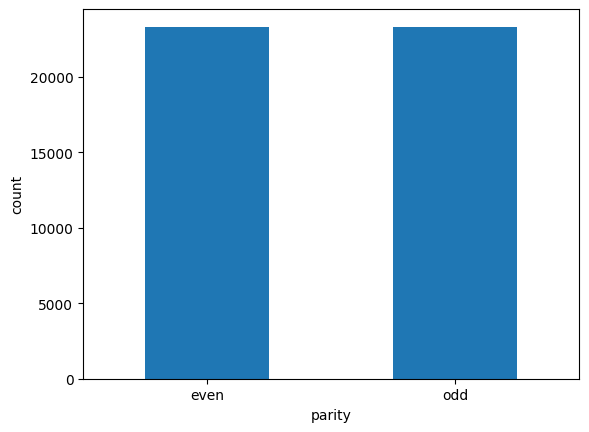

In [8]:
# Look at the distribution of evens/odds in the test data
train_data.parity.value_counts().plot(kind='bar', xlabel='parity', ylabel='count', rot=0)

Parity groups are evenly represented, which looks good. What about digit groups and colors? 

array([[<AxesSubplot:title={'center':'digit'}>]], dtype=object)

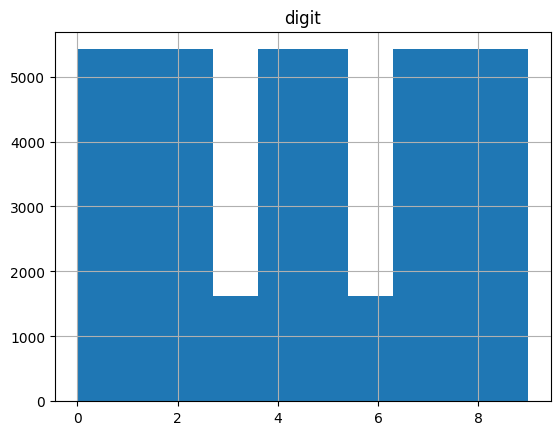

In [9]:
train_data.hist(column='digit')

<AxesSubplot:xlabel='color', ylabel='count'>

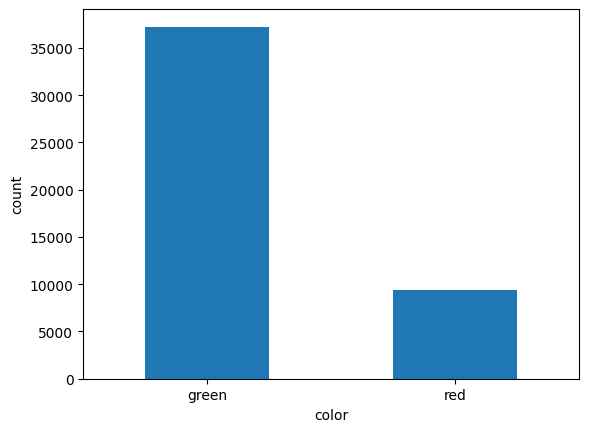

In [10]:
# Look at the distribution of green/red in the training data
train_data.color.value_counts().plot(kind='bar', xlabel='color', ylabel='count', rot=0)

Some digits are well represented, while others are not. The greens are in the majority, while reds are under-represented.

Next we'll see how this can affect classification outcomes, and how to measure the disparities that arise.

We'll start by training a model on train_data and measuring accuracy and bias on test_data.

# Train a baseline model

Now we'll train a neural network to classify images according to their digit identity. 
Code for the method train_model is in the file `models.py`

In [11]:

# importlib.reload(train_utils)
from train_utils import train_model

N_EPOCHS = 3
HIDDEN_DIM = 10
DATA_SHUFFLE_SEED = 0
MODEL_WEIGHT_INIT_SEED = 0

#         This may take 10-20s
base_model = train_model(df=train_data, img_col='img', label_col='digit', colored=True,
                         dataset_name='train_set', net_type='MLP', n_epochs=N_EPOCHS, hidden_dim=HIDDEN_DIM,
                         data_shuffle_seed=DATA_SHUFFLE_SEED, model_weight_init_seed=MODEL_WEIGHT_INIT_SEED)

Train Epoch: 1 [0/46620 (0%)]	Loss: 2.313955
Train Epoch: 1 [6400/46620 (14%)]	Loss: 0.841051
Train Epoch: 1 [12800/46620 (27%)]	Loss: 0.251927
Train Epoch: 1 [19200/46620 (41%)]	Loss: 0.704948
Train Epoch: 1 [25600/46620 (55%)]	Loss: 0.398176
Train Epoch: 1 [32000/46620 (69%)]	Loss: 0.613586
Train Epoch: 1 [38400/46620 (82%)]	Loss: 0.332132
Train Epoch: 1 [44800/46620 (96%)]	Loss: 0.322108
Train Epoch: 2 [0/46620 (0%)]	Loss: 0.304170
Train Epoch: 2 [6400/46620 (14%)]	Loss: 0.410034
Train Epoch: 2 [12800/46620 (27%)]	Loss: 0.312371
Train Epoch: 2 [19200/46620 (41%)]	Loss: 0.393773
Train Epoch: 2 [25600/46620 (55%)]	Loss: 0.420468
Train Epoch: 2 [32000/46620 (69%)]	Loss: 0.463032
Train Epoch: 2 [38400/46620 (82%)]	Loss: 0.226394
Train Epoch: 2 [44800/46620 (96%)]	Loss: 0.276312
Train Epoch: 3 [0/46620 (0%)]	Loss: 0.354664
Train Epoch: 3 [6400/46620 (14%)]	Loss: 0.493218
Train Epoch: 3 [12800/46620 (27%)]	Loss: 0.229269
Train Epoch: 3 [19200/46620 (41%)]	Loss: 0.427343
Train Epoch: 3 [25

# Measure accuracy

First, select the test set. We will use the test_data from our starting data setup.

Run the trained model using this test set as input, and gather model outputs into a new column of our dataframe.

In [12]:
from eval_utils import run_model
results_df = run_model(base_model, test_data, img_col='img', label_col='digit', dataset_name='train_set', pred_col='pred1')

In [13]:
# The results have a new column 'pred1' for model predictions
results_df[['digit','parity','curve','magnitude','color','pred1']].head

<bound method NDFrame.head of       digit parity   curve magnitude  color  pred1
0         7    odd   lines     large    red      7
1         2   even     mix     small  green      2
2         1    odd   lines     small  green      1
3         0   even     mix     small  green      0
4         4   even   lines       med  green      4
...     ...    ...     ...       ...    ...    ...
9995      2   even     mix     small    red      2
9996      3    odd  curves     small  green      3
9997      4   even   lines       med  green      4
9998      5    odd     mix       med  green      5
9999      6   even     mix       med  green      6

[10000 rows x 6 columns]>

Accuracy is a function of how often the model predictions ('pred1' column) match ground truth ('label' column). 

Accuracy over the entire test set is defined as (# examples where prediction == label) / (total # examples).

In [14]:
def compute_accuracy(df, label_col, pred_col):
    return len(df[(df[label_col]==df[pred_col])]) / len(df)

acc = compute_accuracy(results_df, 'label', 'pred1')
print('Accuracy: ', acc)

Accuracy:  0.8685


# Measure bias

A starting metric for bias is absolute disparity: what is the difference in accuracy among groups? 

In Section [Define groups](#define-groups) we defined attributes for our dataset: identity, parity, magnitude, curve, and color. 

Now we will break down accuracy according to these groups, in order to explore disparities, if they exist.

## Bias by identity, color, and curve

Define a convenience function to compute the accuracy across groups 

In [15]:
# Select a subset for each identity value and calculate accuracy on that subset.
import numpy as np

def print_accuracy_by_group(df, group_col='digit', prediction_col='pred1', ground_truth_col='label'):
    for value in np.sort(df[group_col].unique()):
        subset_df = df[df[group_col]==value]
        acc = compute_accuracy(subset_df, prediction_col, ground_truth_col)
        print(f'Accuracy on images with {group_col} {value}: {acc}')

### Digit Identity

In [16]:
# Print accuracy broken down by digit identity
print_accuracy_by_group(results_df, group_col='digit', prediction_col='pred1', ground_truth_col='label')

Accuracy on images with digit 0: 0.95
Accuracy on images with digit 1: 0.973568281938326
Accuracy on images with digit 2: 0.8517441860465116
Accuracy on images with digit 3: 0.5623762376237624
Accuracy on images with digit 4: 0.9093686354378818
Accuracy on images with digit 5: 0.8665919282511211
Accuracy on images with digit 6: 0.8413361169102297
Accuracy on images with digit 7: 0.9416342412451362
Accuracy on images with digit 8: 0.9188911704312115
Accuracy on images with digit 9: 0.8592666005946482


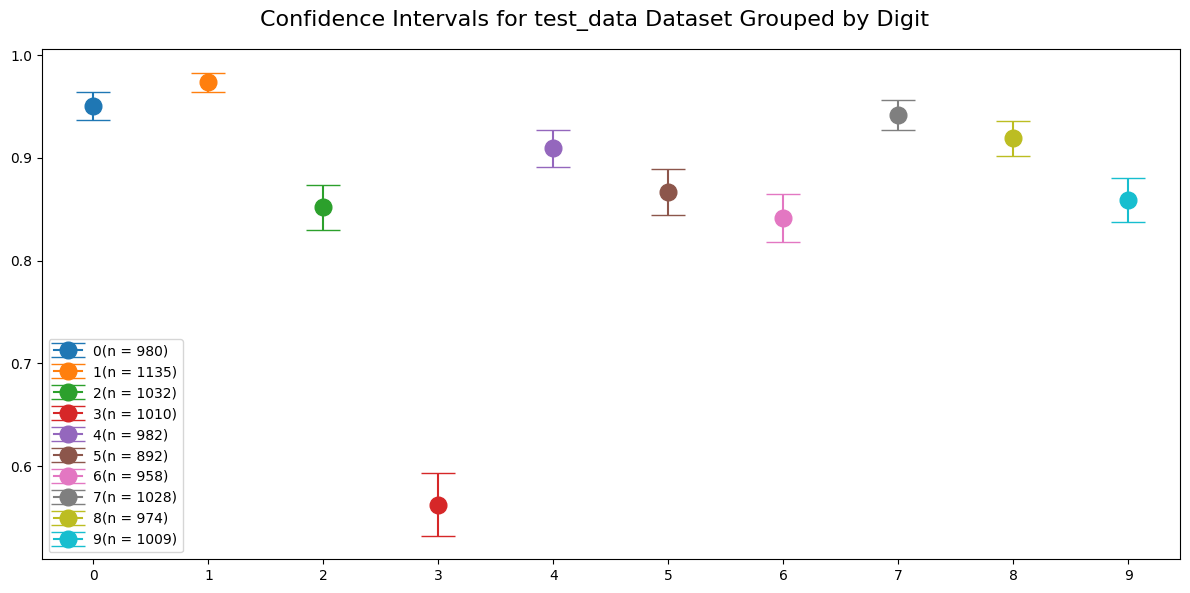

In [17]:
# Plot accuracy broken down by digit identity
plot_confidence_intervals_from_df(df_with_preds=results_df,
                                  label_col='label',
                                  pred_col='pred1',
                                  dataset_name='test_data',
                                  group_name='digit',
                                  x_ticklabels=None,
                                  use_legend=True)

### Color

In [18]:
# Print out accuracy broken down by color
print_accuracy_by_group(results_df, group_col='color', prediction_col='pred1', ground_truth_col='label')

Accuracy on images with color green: 0.8731548661496122
Accuracy on images with color red: 0.849950149551346


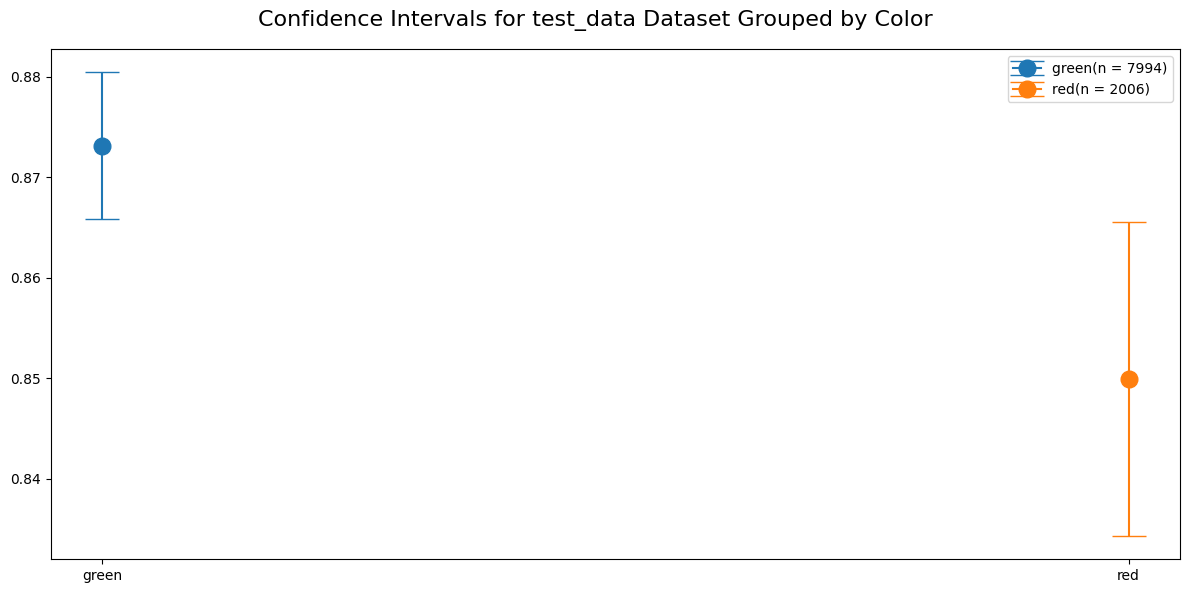

In [19]:
# Plot accuracy broken down by color
plot_confidence_intervals_from_df(df_with_preds=results_df,
                                  label_col='digit',
                                  pred_col='pred1',
                                  dataset_name='test_data',
                                  group_name='color',
                                  x_ticklabels=None,
                                  use_legend=True)

### Curve

In [20]:
# Print accuracy broken down by curve
print_accuracy_by_group(results_df, group_col='curve', prediction_col='pred1', ground_truth_col='label')

Accuracy on images with curve curves: 0.7373991935483871
Accuracy on images with curve lines: 0.9430842607313196
Accuracy on images with curve mix: 0.8737425579963046


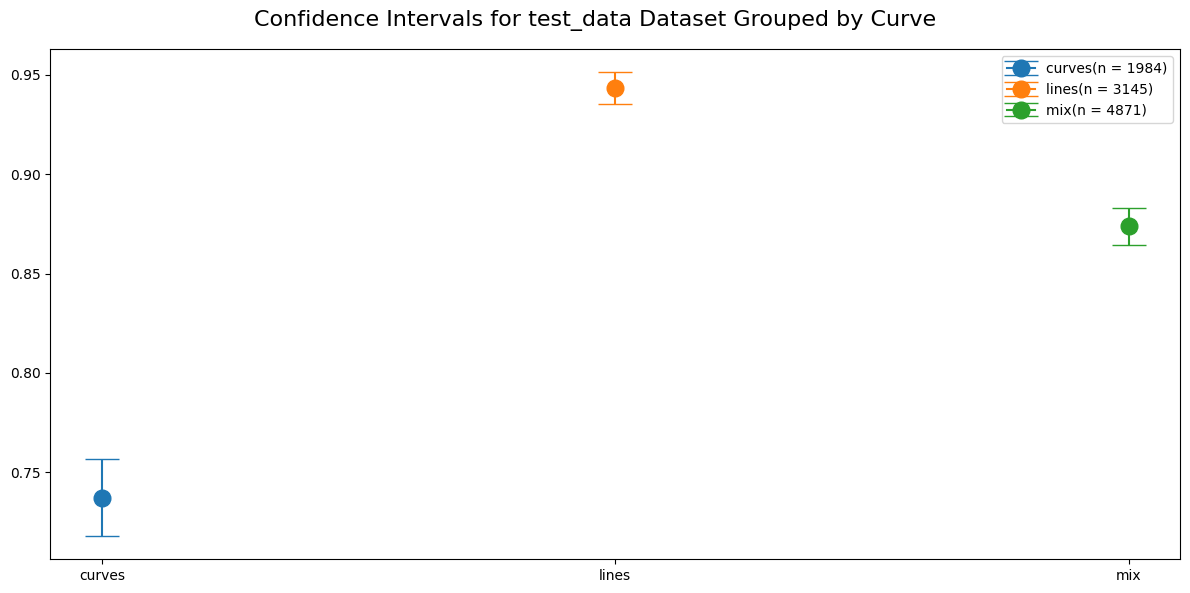

In [21]:
# Plot accuracy broken down by curve
plot_confidence_intervals_from_df(df_with_preds=results_df,
                                  label_col='label',
                                  pred_col='pred1',
                                  dataset_name='test_data',
                                  group_name='curve',
                                  x_ticklabels=None,
                                  use_legend=True)

While overall accuracy is pretty good (90%), breaking out accuracy by identity groups reveals differences.

* Digits: 97% (best group) vs 56% (worst group)
* Colors: 87% (best group) vs 84% (worst group)
* Curve: 94% (best group) vs 73% (worst group)

Next, we'll look at some different metrics for characterizing these differences, and look into potential sources of bias.


# Compare bias metrics

Absolute difference in accuracy is a good starting metric, but it can sometimes obscure meaningful differences between models, or between groups, that are revealed by relative metrics, or by metrics that compute error rather than accuracy.

### Let's review the bias by Color, comparing error and accuracy metrics:

Absolute Best: 87% (Acc), 13% (Err)

Absolute Disparity, difference between Best and Worst groups: 3% (Acc & Err) *Reds experience 3% lower accuracy than greens, maybe this is okay.*

Relative Disparity, ratio between Absolute disparity and Best group: 4% (Acc), 18% (Err) *Reds experience 4% less relative accuracy as greens, but 18% more errors.*

The choice of accuracy or error as a metric of accuracy and bias depends on the application context, and on the types of error that may appear.

### Types of error

* False positive: model predicts 3 when the true number is something else.
* False negative: model predicts something else, when the true number is 3.

To understand these errors, and how the affect groups differently, we can use a confusion matrix. 


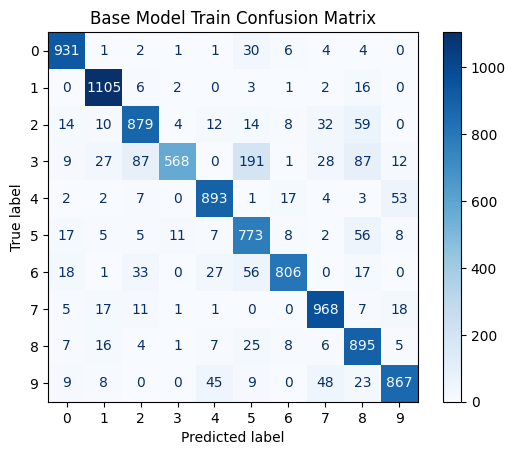

In [22]:
from plotting import plot_confusion_matrix

plot_confusion_matrix(df=results_df, label_col='digit', pred_col='pred1', dataset_name='Base Model Train')

Numbers off the diagonal represent errors. 

For a given digit, false positives are on the vertical above the predicted label for that digit. 

False negatives are on the horizontal, aligned with the true label for that digit.

### Human Oversight and Judgment

False positives and negatives contribute to the calculation of *precision* and *recall*, which are typically in tension with each other. Models can be trained to optimize precision, recall, or a function of the two like F1. This choice is a design decision that depends on the real-world costs that are associated with each type of error in a given context. 

* Boarding pass verification: Cost of false positive may be high if a bad actor gains access. Cost of false negative may be low if it triggers an efficient human double-check.
* Classification of malignant cancer images: Cost of false positive may be low if it triggers medical double-check. Cost of false negative is high if treatment is delayed.

## Intersectionality

What happens when we consider more than one attribute of each image?

In [23]:
# Calculate intersectional accuracies and print them out
def print_accuracy_by_intersection(df, group1_col='digit', group2_col='color', prediction_col='pred1', ground_truth_col='label'):
    for value in np.sort(df[group1_col].unique()):
        for val2 in np.sort(df[group2_col].unique()):
            subset_df = df.loc[(df[group1_col] == value) & (df[group2_col] == val2)]
            #subset_df = df[df[group1_col]==value]
            acc = compute_accuracy(subset_df, prediction_col, ground_truth_col)
            print(f'Accuracy on images with {group1_col}-{group2_col} values {value}-{val2}: {acc}')


In [24]:
print_accuracy_by_intersection(results_df, group1_col='digit', group2_col='color', prediction_col='pred1', ground_truth_col='label')

Accuracy on images with digit-color values 0-green: 0.974587039390089
Accuracy on images with digit-color values 0-red: 0.8497409326424871
Accuracy on images with digit-color values 1-green: 0.9801762114537445
Accuracy on images with digit-color values 1-red: 0.947136563876652
Accuracy on images with digit-color values 2-green: 0.8566221142162819
Accuracy on images with digit-color values 2-red: 0.8325358851674641
Accuracy on images with digit-color values 3-green: 0.553921568627451
Accuracy on images with digit-color values 3-red: 0.5979381443298969
Accuracy on images with digit-color values 4-green: 0.9184713375796179
Accuracy on images with digit-color values 4-red: 0.8730964467005076
Accuracy on images with digit-color values 5-green: 0.8597222222222223
Accuracy on images with digit-color values 5-red: 0.8953488372093024
Accuracy on images with digit-color values 6-green: 0.8303108808290155
Accuracy on images with digit-color values 6-red: 0.8870967741935484
Accuracy on images with

In this breakdown, we can see that disparities within a digit group can be larger than overall disparity.

Overall, reds experience similar accuracy to greens (84% vs 87%). 

Overall, nines experience accuracy near the average (85% vs 87%). 

However red nines in this dataset experience much lower accuracy than the average (78% vs 87%), and much lower accuracy than green nines (78% vs 88%).

## Conslusions

In this workshop we practiced skills required to generate and interpret a bias report, including: 
* Train a baseline model
* Measure classification accuracy
* Measure and visualize bias: disparities in accuracy for subsets of the data
* Compare bias metrics: relative vs. absolute, error vs. accuracy
* Explore intersectional bias


This notebook is available online at https://github.com/aws-samples/reinvent2022-advancing-responsible-ai
